In [98]:

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
#import matplotlib.pyplot as plt
import torch

import defmod as dm
import defmod.multimodule_usefulfunctions as mm

torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
gd = torch.tensor([[1.,0.]], requires_grad=True).view(-1)
manifold = dm.manifold.Landmarks(dim=2, nb_pts=1, gd=gd, cotan=torch.tensor([0.,50.], requires_grad=True))

gd2 = torch.tensor([[0.,0.]], requires_grad=True).view(-1)
manifold2 = dm.manifold.Landmarks(dim=2, nb_pts=1, gd=gd2, cotan=torch.tensor([0.,0.5], requires_grad=True))

silent = dm.deformationmodules.SilentPoints(manifold)

translations = dm.deformationmodules.Translations(manifold2, sigma=0.5)

man_scal1 = dm.manifold.Landmarks(2, 1, gd=torch.tensor([2.5, 2.5], requires_grad = True).view(-1))
scal = dm.deformationmodules.ConstrainedTranslations_Scaling(man_scal1, sigma = 1.)
mod = scal

In [200]:
# Visualization of grid deformation for each submodule
xmin = -5
xmax = 5
ymin = -5
ymax = 5
dx = 0.2
dy = 0.2
nx = int((xmax-xmin)/dx)
ny = int((ymax-ymin)/dy)
x,y,gridpos = mm.gridpoints(xmin, xmax, ymin, ymax, dx, dy)

In [201]:
man_grid = dm.manifold.Landmarks(dim=2, nb_pts=len(gridpos), gd=gridpos.view(-1).requires_grad_())
silent_grid = dm.deformationmodules.SilentPoints(man_grid)
comp = dm.deformationmodules.CompoundModule([mod, translations, silent, silent_grid])
H = dm.hamiltonian.Hamiltonian(comp)

In [202]:
#comp.manifold[0].fill_cotan(torch.tensor([[-1.,0.],[0.,1.], [1.,-1.], [-1.5,0.8]], requires_grad=True).view(-1))
#H.module.manifold[0].fill_cotan(torch.ones_like(H.module.manifold[0].cotan))
H.geodesic_controls()
H.module.controls

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


[tensor([-2.7219], grad_fn=<MulBackward0>),
 tensor([0.0000, 7.2668], grad_fn=<MulBackward0>),
 tensor([], requires_grad=True),
 tensor([], requires_grad=True)]

In [203]:
H.module.manifold.cotan

[tensor([0., 0.], grad_fn=<ViewBackward>),
 tensor([0.0000, 0.5000], requires_grad=True),
 tensor([ 0., 50.], requires_grad=True),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<ViewBackward>)]

In [204]:
states, controls = dm.shooting.shoot_euler(H, it=10)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


In [205]:
s.gd[1].detach().view(-1,2)

tensor([[1.0005, 0.4508]])

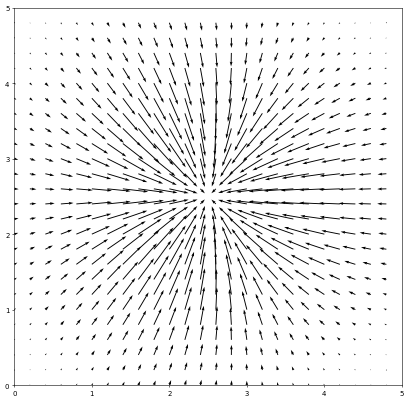

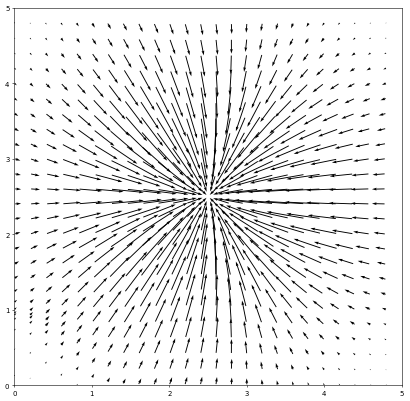

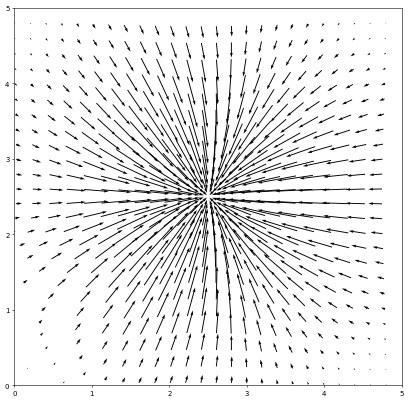

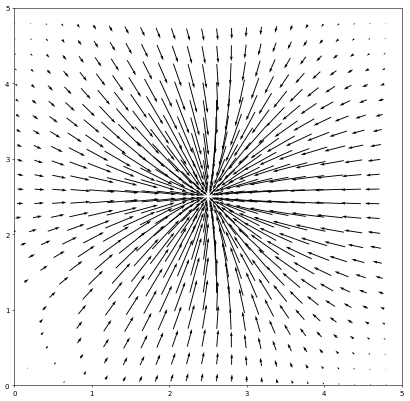

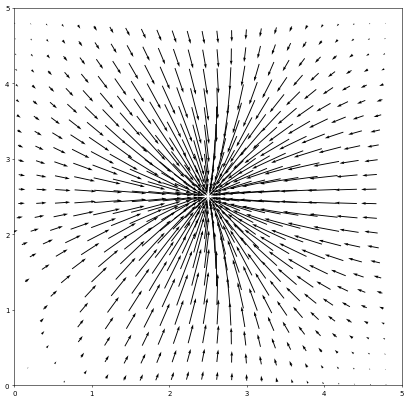

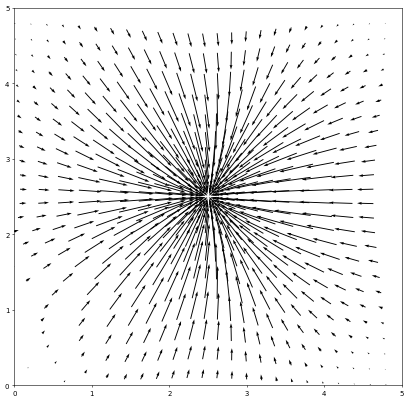

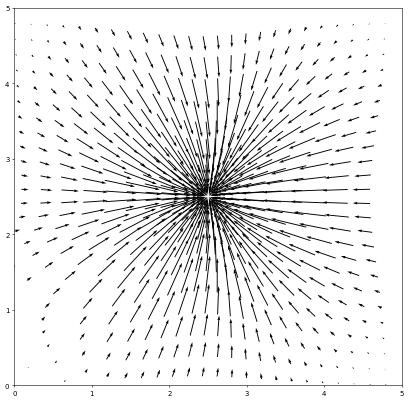

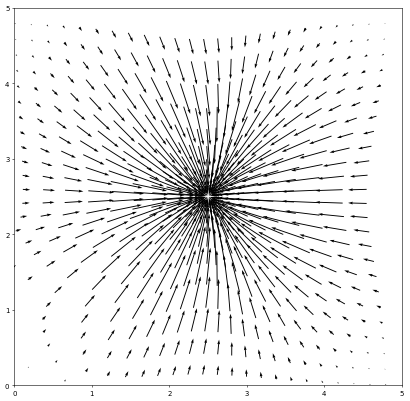

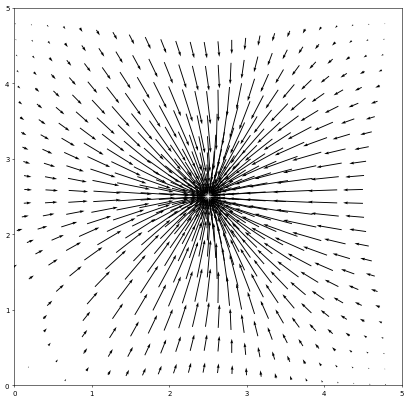

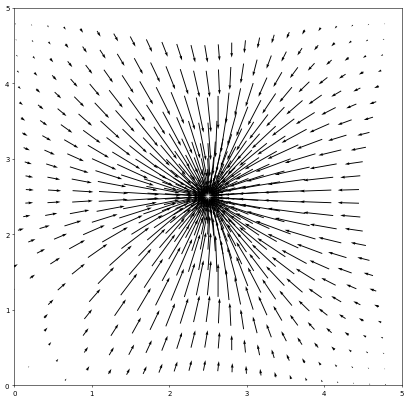

In [206]:
figsize = (10,10)
dpi=(50)
xmin = 0
xmax = 5
ymin = 0
ymax = 5

#cotan = translations.manifold.cotan.detach().view(-1,2)
#gd = gd.detach().view(-1,2)
#controls = translations.controls.detach().view(-1,2)

import matplotlib.pyplot as plt

fig_fieldlist = []
for s, c in zip(states, controls):
    H.module.fill_controls(c)
    p = s.gd[-1].detach().view(-1,2)
    field = H.module.field_generator()(p)
    fig_fieldlist.append(plt.figure(figsize=figsize, dpi=dpi))
    #plt.scatter(torch.cat(s.gd).detach().view(-1,2)[:,0], torch.cat(s.gd).detach().view(-1,2)[:,1], c='r', marker='X', s=200)
    plt.quiver(p.detach()[:,0],p.detach()[:,1], field.detach()[:,0], field.detach()[:,1], scale=10)
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
plt.show()


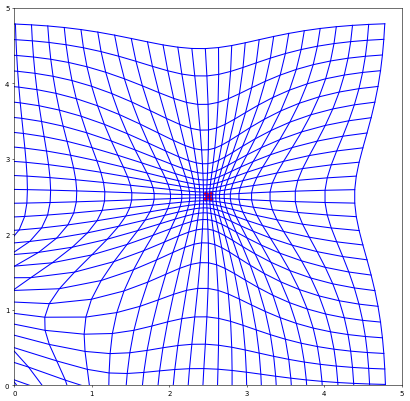

In [207]:
grid_final = states[-1].gd[-1]
x1, y1 = dm.usefulfunctions.vec2grid(grid_final.view(-1,2), nx,ny)

fig_grid = mm.plot_grid(x1.detach().numpy(), y1.detach().numpy(), color = 'blue', xlim=[0.,5.], ylim=[0.,5.], figsize=figsize, dpi=dpi)
plt.scatter(states[-1][0].gd.detach().view(-1,2)[:,0],states[-1][0].gd.detach().view(-1,2)[:,1], color='red', marker='X', s=200) 
plt.show()